# Preparing the environment

In [ ]:
! pip3 install tf-models-official

     |████████████████████████████████| 2.2 MB 5.3 MB/s 
     |████████████████████████████████| 43 kB 2.1 MB/s 
     |████████████████████████████████| 1.2 MB 38.2 MB/s 
     |████████████████████████████████| 4.9 MB 33.7 MB/s 
     |████████████████████████████████| 90 kB 9.5 MB/s 
     |████████████████████████████████| 352 kB 45.9 MB/s 
     |████████████████████████████████| 636 kB 43.2 MB/s 
     |████████████████████████████████| 237 kB 48.2 MB/s 
     |████████████████████████████████| 99 kB 8.6 MB/s 
     |████████████████████████████████| 47.8 MB 2.0 MB/s 
     |████████████████████████████████| 1.1 MB 39.0 MB/s 
     |████████████████████████████████| 462 kB 48.8 MB/s 
  Created wheel for py-cpuinfo: filename=py_cpuinfo-8.0.0-py3-none-any.whl size=22257 sha256=764ffdb9808c1b8593d7f9b9dd5fa44c8cda625f4f3e33f9a74842c2c811cf89
  Stored in directory: /root/.cache/pip/wheels/d2/f1/1f/041add21dc9c4220157f1bd2bd6afe1f1a49524c3396b94401
  Created wheel for seqeval: filename=seqeval-

In [ ]:
! pip install tensorflow-text

In [ ]:
import numpy as np
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import gc # garbage collections
import bz2 # to open zipped files
import tensorflow as tf
from tensorflow import keras
from keras import models, layers
# more libraries for BERT
import tensorflow_hub as hub
import tensorflow_text as text
from official.nlp import optimization # to create AdamW optimizer

tf.get_logger().setLevel('ERROR')

In [ ]:
! pip install kaggle 
! mkdir ~/.kaggle
! cp /content/drive/MyDrive/kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

! kaggle datasets download -d bittlingmayer/amazonreviews
! unzip /content/amazonreviews.zip -d /content/amazonreviews

 99% 489M/493M [00:04<00:00, 131MB/s]
100% 493M/493M [00:04<00:00, 126MB/s]
Archive:  /content/amazonreviews.zip
  inflating: /content/amazonreviews/test.ft.txt.bz2  
  inflating: /content/amazonreviews/train.ft.txt.bz2  


In [ ]:
# read the files
train = bz2.BZ2File('/content/amazonreviews/train.ft.txt.bz2')
test = bz2.BZ2File('/content/amazonreviews/test.ft.txt.bz2')

train = train.readlines()
test = test.readlines()

# convert from raw binary strings into text files that can be parsed
train = [x.decode('utf-8') for x in train]
test = [x.decode('utf-8') for x in test]

# extract the labels
train_labels = [0 if x.split(' ')[0] == '__label__1' else 1 for x in train] 
test_labels = [0 if x.split(' ')[0] =='__label__1' else 1 for x in test]

# extract the texts
train_texts = [x.split(' ', maxsplit=1)[1][:-1] for x in train]
test_texts = [x.split(' ', maxsplit=1)[1][:-1] for x in test]

# let's convert the labels to numpy arrays
# labels = np.array(train_labels)

del train, test
gc.collect()

22

In [ ]:
texts = train_texts[:100000]
labels = train_labels[:100000]

val_texts = train_texts[100001:120000]
val_labels = train_labels[100001:120000]

In [ ]:
# Choosing a BERT Model to fine-tune
bert_model_name = 'small_bert/bert_en_uncased_L-4_H-512_A-8'

tfhub_handle_encoder = 'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1'
tfhub_handle_preprocess = 'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3'

print(f'BERT model selected           : {tfhub_handle_encoder}')
print(f'Preprocess model auto-selected: {tfhub_handle_preprocess}')

BERT model selected           : https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1
Preprocess model auto-selected: https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3


In [ ]:
# Preprocessing
bert_preprocess_model = hub.KerasLayer(tfhub_handle_preprocess)

# test
text_test = ['this is such an amazing movie!']
text_preprocessed = bert_preprocess_model(text_test)

print(f'Keys       : {list(text_preprocessed.keys())}')
print(f'Shape      : {text_preprocessed["input_word_ids"].shape}')
print(f'Word Ids   : {text_preprocessed["input_word_ids"][0, :12]}')
print(f'Input Mask : {text_preprocessed["input_mask"][0, :12]}')
print(f'Type Ids   : {text_preprocessed["input_type_ids"][0, :12]}')

Keys       : ['input_word_ids', 'input_type_ids', 'input_mask']
Shape      : (1, 128)
Word Ids   : [ 101 2023 2003 2107 2019 6429 3185  999  102    0    0    0]
Input Mask : [1 1 1 1 1 1 1 1 1 0 0 0]
Type Ids   : [0 0 0 0 0 0 0 0 0 0 0 0]


In [ ]:
def build_classifier_model():
  text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
  preprocessing_layer = hub.KerasLayer(tfhub_handle_preprocess, name='preprocessing')
  encoder_inputs = preprocessing_layer(text_input)
  encoder = hub.KerasLayer(tfhub_handle_encoder, trainable=True, name='BERT_encoder')
  outputs = encoder(encoder_inputs)
  net = outputs['pooled_output']
  net = tf.keras.layers.Dropout(0.1)(net)
  net = tf.keras.layers.Dense(1, activation='sigmoid', name='classifier')(net)
  return tf.keras.Model(text_input, net)

In [ ]:
model = build_classifier_model()
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 text (InputLayer)              [(None,)]            0           []                               
                                                                                                  
 preprocessing (KerasLayer)     {'input_word_ids':   0           ['text[0][0]']                   
                                (None, 128),                                                      
                                 'input_mask': (Non                                               
                                e, 128),                                                          
                                 'input_type_ids':                                                
                                (None, 128)}                                                

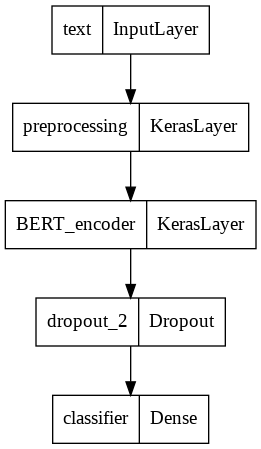

In [ ]:
tf.keras.utils.plot_model(model)

In [ ]:
# define the loss, metrics and optimizer
loss = tf.keras.losses.BinaryCrossentropy()
metrics = tf.metrics.BinaryAccuracy(name='accuracy')

epochs = 5
dataset = tf.data.Dataset.range(1000)
steps_per_epoch = tf.data.experimental.cardinality(dataset).numpy()
num_train_steps = steps_per_epoch * epochs
num_warmup_steps = int(0.1*num_train_steps)

init_lr = 3e-5
optimizer = optimization.create_optimizer(init_lr=init_lr,
                                          num_train_steps=num_train_steps,
                                          num_warmup_steps=num_warmup_steps,
                                          optimizer_type='adamw')

In [ ]:
model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

In [ ]:
history = model.fit(texts, labels, epochs=epochs, validation_data=(val_texts, val_labels))

Epoch 1/5
3125/3125 [==============================] - 1480s 471ms/step - loss: 0.2468 - accuracy: 0.8975 - val_loss: 0.1655 - val_accuracy: 0.9388
Epoch 2/5
3125/3125 [==============================] - 1470s 470ms/step - loss: 0.1493 - accuracy: 0.9458 - val_loss: 0.1644 - val_accuracy: 0.9413
Epoch 3/5
3125/3125 [==============================] - 1462s 468ms/step - loss: 0.1363 - accuracy: 0.9516 - val_loss: 0.1644 - val_accuracy: 0.9413
Epoch 4/5
3125/3125 [==============================] - 1457s 466ms/step - loss: 0.1354 - accuracy: 0.9514 - val_loss: 0.1644 - val_accuracy: 0.9413
Epoch 5/5
3125/3125 [==============================] - 1466s 469ms/step - loss: 0.1361 - accuracy: 0.9505 - val_loss: 0.1644 - val_accuracy: 0.9413


In [ ]:
model.evaluate(test_texts[:40000], test_labels[:40000])

1250/1250 [==============================] - 259s 206ms/step - loss: 0.1859 - accuracy: 0.9353


[0.1859474629163742, 0.9352750182151794]

In [ ]:
test_texts[:3]

['Great CD: My lovely Pat has one of the GREAT voices of her generation. I have listened to this CD for YEARS and I still LOVE IT. When I\'m in a good mood it makes me feel better. A bad mood just evaporates like sugar in the rain. This CD just oozes LIFE. Vocals are jusat STUUNNING and lyrics just kill. One of life\'s hidden gems. This is a desert isle CD in my book. Why she never made it big is just beyond me. Everytime I play this, no matter black, white, young, old, male, female EVERYBODY says one thing "Who was that singing ?"',
 "One of the best game music soundtracks - for a game I didn't really play: Despite the fact that I have only played a small portion of the game, the music I heard (plus the connection to Chrono Trigger which was great as well) led me to purchase the soundtrack, and it remains one of my favorite albums. There is an incredible mix of fun, epic, and emotional songs. Those sad and beautiful tracks I especially like, as there's not too many of those kinds of s

In [ ]:
model.predict(test_texts[:3])

array([[0.99632204],
       [0.99634176],
       [0.00347024]], dtype=float32)

In [ ]:
model.save('BERT_amazon.h5')

In [42]:
model.save('bert_amazon.h5')

In [43]:

# copy the model
! cp /content/bert_amazon.h5 -d /content/drive/MyDrive